# Notes
Overnight training on laptop, but output is just noise. Checked the discriminator, and it is correctly classifying images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os
from utils import load_img, resize_crop, imshow, interleave
%matplotlib inline

# Global params

In [2]:
img_directory = '/Users/rwilliams/Desktop/celeba/training'
img_save_directory = '/Users/rwilliams/Desktop/celeba/out'
# save / load model here
model_weights_path = '/Users/rwilliams/Desktop/celeba/celeba-vaegan-weights.hdf5'
batch_size = 64
# training_set_size = 4992
training_set_size = 2048
img_size = 64

# Load training data

In [3]:
training = np.array([resize_crop(load_img(i+1, img_directory), (img_size, img_size)) for i in range(training_set_size)])

/Users/rwilliams/anaconda/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


# Create model and load weights

Instantiate model

In [4]:
from autoencoder import Autoencoder
from discriminator import Discriminator
from keras.optimizers import Adam

vae = Autoencoder(img_shape=(img_size, img_size, 3), batch_size=batch_size)
vae.build_model()

disc = Discriminator(img_shape=(img_size, img_size, 3), batch_size=batch_size)
disc.build_model()

Using TensorFlow backend.


(None, 256)


In [5]:
optimizer = Adam(lr=.00001)

# Train

Given real image training data, constructs a training set for the discriminator consisting of the real images, autoencoder coded then decoded images, and images generated by decoding a sample fro z. Returns tuple (training, labels).

In [14]:
def generate_disc_training_data(images, vae, batch_size, img_rows, img_cols, channels=3):
    data_set_size = images.shape[0]
    # real images encoded, then decoded
    encdec = vae.model.predict(images, batch_size=batch_size)
    # sampled from z then decoded. Do for as many as number of images.
    sampled = vae.decoder.predict(np.random.normal(size=(data_set_size, vae.zsize)), batch_size=batch_size)
        
    training = interleave(images, encdec, sampled)
    # 0 for real, 1 for fake
    labels = interleave(np.zeros(data_set_size), np.ones(data_set_size), np.ones(data_set_size))
    return (training, labels)

import keras.backend as K
def decoder_loss_factory(disc):
    def decoder_loss(y_true, y_pred):
        #similarity = disc.diff_loss(y_true, y_pred)
        discriminator_out = K.log(1 - disc.model(y_pred))
#         return similarity - discriminator_out
        return discriminator_out
    return decoder_loss

# Debugging
Getting NaN when training 'train decoder' for loss

In [16]:
# train vae decoder
vae.mode('train_decoder')
decoder_loss = decoder_loss_factory(disc)
vae.model.compile(optimizer, decoder_loss)
vae.model.fit(training, training, epochs=1, batch_size=batch_size, verbose=True)

Epoch 1/1
2048/2048 [==============================] - 63s - loss: nan    


Trying to evaluate disc_training directly

In [41]:
K.set_learning_phase(1.0)
K.learning_phase()

1.0

In [42]:
sess = K.get_session()
y = decoder_loss(
    K.variable(value=disc_training[:9]), 
    K.variable(value=disc_training[:9]))
y.eval(session=sess)

AttributeError: 'float' object has no attribute 'dtype'

In [8]:
epochs = 10
for i in range(100):
    # every ten iterations, train the discriminator
    if (i % 10 == 0):
        # train discriminator
        disc_training, disc_labels = generate_disc_training_data(training, vae, batch_size, img_size, img_size)
        disc.model.compile(optimizer, 'binary_crossentropy')
        disc.model.fit(disc_training, disc_labels, epochs=epochs, batch_size=batch_size, verbose=True)

    # train vae encoder
    vae.mode('train_encoder')
    vae.model.compile(optimizer, disc.diff_loss)
    vae.model.fit(training, training, epochs=epochs, batch_size=batch_size, verbose=True)

    # train vae decoder
    vae.mode('train_decoder')
    decoder_loss = decoder_loss_factory(disc)
    vae.model.compile(optimizer, decoder_loss)
    vae.model.fit(training, training, epochs=epochs, batch_size=batch_size, verbose=True)

Epoch 1/10
6144/6144 [==============================] - 41s - loss: 0.0411    
Epoch 2/10
6144/6144 [==============================] - 40s - loss: 0.0028    
Epoch 3/10
6144/6144 [==============================] - 40s - loss: 0.0018    
Epoch 4/10
6144/6144 [==============================] - 43s - loss: 0.0011    
Epoch 5/10
6144/6144 [==============================] - 44s - loss: 8.8171e-04    
Epoch 6/10
6144/6144 [==============================] - 41s - loss: 7.0805e-04    
Epoch 7/10
6144/6144 [==============================] - 41s - loss: 5.8586e-04    
Epoch 8/10
6144/6144 [==============================] - 41s - loss: 5.4388e-04    
Epoch 9/10
6144/6144 [==============================] - 42s - loss: 4.1684e-04    
Epoch 10/10
6144/6144 [==============================] - 41s - loss: 3.5018e-04    
Epoch 1/10
2048/2048 [==============================] - 37s - loss: 2546.0680    
Epoch 2/10
2048/2048 [==============================] - 37s - loss: 1025.3872    
Epoch 3/10
2048/2048 

2048/2048 [==============================] - 65s - loss: 2.8662    
Epoch 4/10
2048/2048 [==============================] - 65s - loss: 2.7726    
Epoch 5/10
2048/2048 [==============================] - 65s - loss: 2.8367    
Epoch 6/10
2048/2048 [==============================] - 65s - loss: 2.8053    
Epoch 7/10
2048/2048 [==============================] - 66s - loss: 2.8084    
Epoch 8/10
2048/2048 [==============================] - 65s - loss: 2.8171    
Epoch 9/10
2048/2048 [==============================] - 65s - loss: 2.8079    
Epoch 10/10
2048/2048 [==============================] - 65s - loss: 2.8327    
Epoch 1/10
2048/2048 [==============================] - 38s - loss: 10.1744    
Epoch 2/10
2048/2048 [==============================] - 38s - loss: 3.4851    
Epoch 3/10
2048/2048 [==============================] - 37s - loss: 2.8905    
Epoch 4/10
2048/2048 [==============================] - 37s - loss: 2.7265    
Epoch 5/10
2048/2048 [==============================] - 37s -

2048/2048 [==============================] - 65s - loss: 1.1881    
Epoch 7/10
2048/2048 [==============================] - 65s - loss: 1.1728    
Epoch 8/10
2048/2048 [==============================] - 65s - loss: 1.1773    
Epoch 9/10
2048/2048 [==============================] - 65s - loss: 1.1831    
Epoch 10/10
2048/2048 [==============================] - 65s - loss: 1.1679    
Epoch 1/10
6144/6144 [==============================] - 43s - loss: 0.0021    
Epoch 2/10
6144/6144 [==============================] - 42s - loss: 4.0950e-04    
Epoch 3/10
6144/6144 [==============================] - 42s - loss: 8.7013e-05    
Epoch 4/10
6144/6144 [==============================] - 41s - loss: 6.5736e-05    
Epoch 5/10
6144/6144 [==============================] - 41s - loss: 8.5241e-05    
Epoch 6/10
6144/6144 [==============================] - 41s - loss: 3.5395e-05    
Epoch 7/10
6144/6144 [==============================] - 41s - loss: 5.2085e-05    
Epoch 8/10
6144/6144 [================

2048/2048 [==============================] - 37s - loss: 0.6499    
Epoch 10/10
2048/2048 [==============================] - 37s - loss: 0.6799    
Epoch 1/10
2048/2048 [==============================] - 67s - loss: 0.7136    
Epoch 2/10
2048/2048 [==============================] - 65s - loss: 0.6862    
Epoch 3/10
2048/2048 [==============================] - 65s - loss: 0.6865    
Epoch 4/10
2048/2048 [==============================] - 65s - loss: 0.6999    
Epoch 5/10
2048/2048 [==============================] - 65s - loss: 0.6870    
Epoch 6/10
2048/2048 [==============================] - 65s - loss: 0.7009    
Epoch 7/10
2048/2048 [==============================] - 66s - loss: 0.6887    
Epoch 8/10
2048/2048 [==============================] - 65s - loss: 0.6949    
Epoch 9/10
2048/2048 [==============================] - 65s - loss: 0.6923    
Epoch 10/10
2048/2048 [==============================] - 66s - loss: 0.6882    
Epoch 1/10
2048/2048 [==============================] - 39s -

2048/2048 [==============================] - 65s - loss: 0.4818    
Epoch 3/10
2048/2048 [==============================] - 65s - loss: 0.4834    
Epoch 4/10
2048/2048 [==============================] - 65s - loss: 0.4838    
Epoch 5/10
2048/2048 [==============================] - 65s - loss: 0.4872    
Epoch 6/10
2048/2048 [==============================] - 65s - loss: 0.4798    
Epoch 7/10
2048/2048 [==============================] - 66s - loss: 0.4822    
Epoch 8/10
2048/2048 [==============================] - 65s - loss: 0.4781    
Epoch 9/10
2048/2048 [==============================] - 65s - loss: 0.4763    
Epoch 10/10
2048/2048 [==============================] - 65s - loss: 0.4890    
Epoch 1/10
6144/6144 [==============================] - 45s - loss: 6.2856e-04    
Epoch 2/10
6144/6144 [==============================] - 42s - loss: 2.4283e-05    
Epoch 3/10
6144/6144 [==============================] - 42s - loss: 8.6876e-06    
Epoch 4/10
6144/6144 [============================

2048/2048 [==============================] - 37s - loss: 0.2975    
Epoch 6/10
2048/2048 [==============================] - 37s - loss: 0.2958    
Epoch 7/10
2048/2048 [==============================] - 37s - loss: 0.2941    
Epoch 8/10
2048/2048 [==============================] - 37s - loss: 0.2880    
Epoch 9/10
2048/2048 [==============================] - 38s - loss: 0.2945    
Epoch 10/10
2048/2048 [==============================] - 37s - loss: 0.2889    
Epoch 1/10
2048/2048 [==============================] - 69s - loss: 0.3945    
Epoch 2/10
2048/2048 [==============================] - 65s - loss: 0.3587    
Epoch 3/10
2048/2048 [==============================] - 65s - loss: 0.3610    
Epoch 4/10
2048/2048 [==============================] - 65s - loss: 0.3568    
Epoch 5/10
2048/2048 [==============================] - 67s - loss: 0.3548    
Epoch 6/10
2048/2048 [==============================] - 65s - loss: 0.3586    
Epoch 7/10
2048/2048 [==============================] - 65s - 

2048/2048 [==============================] - 37s - loss: 0.2132    
Epoch 9/10
2048/2048 [==============================] - 37s - loss: 0.2103    
Epoch 10/10
2048/2048 [==============================] - 37s - loss: 0.2044    
Epoch 1/10
2048/2048 [==============================] - 70s - loss: 0.2919    
Epoch 2/10
2048/2048 [==============================] - 65s - loss: 0.2748    
Epoch 3/10
2048/2048 [==============================] - 66s - loss: 0.2711    
Epoch 4/10
2048/2048 [==============================] - 66s - loss: 0.2732    
Epoch 5/10
2048/2048 [==============================] - 65s - loss: 0.2725    
Epoch 6/10
2048/2048 [==============================] - 65s - loss: 0.2717    
Epoch 7/10
2048/2048 [==============================] - 65s - loss: 0.2708    
Epoch 8/10
2048/2048 [==============================] - 65s - loss: 0.2716    
Epoch 9/10
2048/2048 [==============================] - 65s - loss: 0.2680    
Epoch 10/10
2048/2048 [==============================] - 66s -

2048/2048 [==============================] - 42s - loss: 7.7267    
Epoch 2/10
2048/2048 [==============================] - 37s - loss: 0.4726    
Epoch 3/10
2048/2048 [==============================] - 37s - loss: 0.1883    
Epoch 4/10
2048/2048 [==============================] - 37s - loss: 0.1632    
Epoch 5/10
2048/2048 [==============================] - 37s - loss: 0.1624    
Epoch 6/10
2048/2048 [==============================] - 37s - loss: 0.1603    
Epoch 7/10
2048/2048 [==============================] - 37s - loss: 0.1586    
Epoch 8/10
2048/2048 [==============================] - 37s - loss: 0.1546    
Epoch 9/10
2048/2048 [==============================] - 37s - loss: 0.1527    
Epoch 10/10
2048/2048 [==============================] - 37s - loss: 0.1540    
Epoch 1/10
2048/2048 [==============================] - 69s - loss: 0.2654    
Epoch 2/10
2048/2048 [==============================] - 64s - loss: 0.2225    
Epoch 3/10
2048/2048 [==============================] - 64s - 

KeyboardInterrupt: 

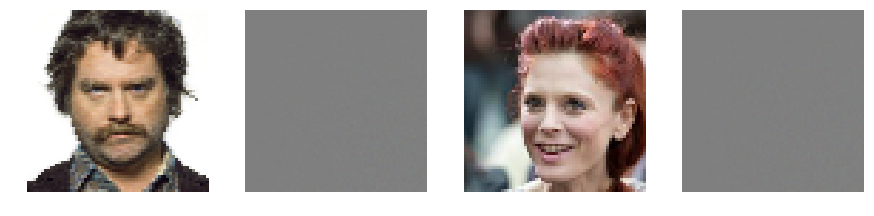

In [7]:
predictions = vae.model.predict(training[:batch_size], batch_size=batch_size)
imshow([training[0], predictions[0], training[1], predictions[1]])

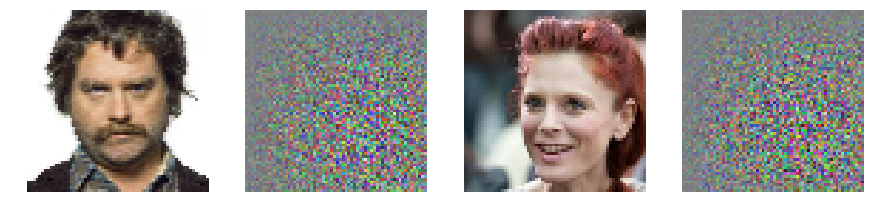

In [9]:
predictions = vae.model.predict(training[:batch_size], batch_size=batch_size)
imshow([training[0], predictions[0], training[1], predictions[1]])

In [12]:
y = disc.model.predict(disc_training, batch_size=batch_size)

[array([  4.95115782e-10], dtype=float32),
 array([ 0.99999988], dtype=float32),
 array([ 0.99999976], dtype=float32),
 array([  2.72404321e-11], dtype=float32),
 array([ 0.99999976], dtype=float32),
 array([ 0.99999964], dtype=float32),
 array([  2.66514064e-08], dtype=float32),
 array([ 0.99999988], dtype=float32),
 array([ 0.99999988], dtype=float32)]